In [90]:
from __future__ import print_function
import os
RNB_PLANNING_DIR = os.environ["RNB_PLANNING_DIR"]
os.chdir(os.path.join(RNB_PLANNING_DIR, 'src'))
from pkg.controller.combined_robot import *
from pkg.utils.utils import get_now, try_mkdir
import subprocess

DATA_PATH = os.path.join(RNB_PLANNING_DIR, "data")
try_mkdir(DATA_PATH)

TEST_DATA_PATH = os.path.join(DATA_PATH, "filters")
try_mkdir(TEST_DATA_PATH)

HEADS = ["plan_time", "length", "MP_tot", "MP_count", "failed_MPs", "IK_tot", "IK_count", "failed_IKs", "success"]
DISPS = ["Time", "Actions", "MP_tot", "MPs", "MP fails", "IK_tot", "IKs", "IK fails", "Failures", "Total"]
H2D = {}
D2H = {}
for head, disp in zip(HEADS, DISPS):
    H2D[head] = disp
    D2H[disp] = head

RTYPE = "indy7gripper"
DAT_DIR = '20210708-064926'

# RTYPE = "panda"
# DAT_DIR = '20210705-182244'
# FILE_OPTION = "obj_1"
# # DAT_DIR, FILE_OPTION = "20210613-022832", "obj_1"
# # # DAT_DIR, FILE_OPTION = "20210612-221934", "obj_1"

CNAME_LIST = ['None','Tool','ToolReach','Full'] #,'Pairwise']
GRASP_SAMPLE = 100
VISUALIZE = True
PLAY_RESULT = False
SHOW_STATE = False

TIMEOUT_MOTION = 5
MAX_TIME = 100
MAX_ITER = 100

ROBOT_DATA_ROOT = os.path.join(TEST_DATA_PATH, RTYPE)
DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, DAT_DIR)
file_list = sorted(os.listdir(DATASET_PATH))

res_dict_all = defaultdict(lambda: defaultdict(list))
resfile_list = sorted(os.listdir(os.path.join(DATASET_PATH)))
for resfile in resfile_list:
    args = resfile[:-4].split("_")[1:]
    f_option = "_".join(args[:-2])
    fid, cname = args[-2:]
    resdat = load_pickle(os.path.join(DATASET_PATH, resfile))
    res_dict_all[f_option][cname].append([resdat[head] if head in resdat else None for head in HEADS])
    
exp_list = ['1_plane', '3_plane', '3_shelf', '3_pole']
for ekey in exp_list:
    if ekey not in res_dict_all:
        continue
    res_dict = res_dict_all[ekey]
    
    succ_vec_list = []
    len_list = []
    None_cols = []
    CNAME_LIST_CUR = [cname for cname in CNAME_LIST if cname in res_dict]
    for cname in CNAME_LIST_CUR:
        vv = np.array(res_dict[cname])
        if len(vv)>0:
            None_cols.append(np.any(np.equal(vv, None), axis=0))
            succ_vec = vv[:,-1]
            succ_vec_list.append(succ_vec)
            len_list.append(len(succ_vec))
            if cname == CNAME_LIST_CUR[0]:
                fail_vec = np.logical_not(succ_vec)
                idc_fail_none = np.where(fail_vec)[0]
    print("="*30 + " {:<10} ".format(ekey) + "="*30)
    if len(len_list)>1:
        None_cols = np.any(None_cols, 0)
        good_cols = np.where(np.logical_not(None_cols))[0]
        print(("{:<10}:"+ " {:<10}"*len(good_cols)).format(
            "Checker", *[DISPS[gidx] for gidx in good_cols])+" {:<10}".format(DISPS[-1]))
        min_len = np.min(len_list[1:])
        succ_vec_all = np.all([svec[:min_len] for svec in succ_vec_list[1:]], axis=0)
        idc_succ_all = np.where(succ_vec_all)[0]

        hard_vec_list = []
        for cname in CNAME_LIST_CUR:
            vv = np.array(res_dict[cname])[:, good_cols]
            if len(vv)>0:
                succ_vec = vv[:,-1]
                fail_vec = np.logical_not(succ_vec)
                hard_vec_list.append(vv[:min_len, 0] > np.mean(vv[:min_len, 0])*1.0)
                if cname == CNAME_LIST_CUR[0]:
                    idc_succ_now = np.where(succ_vec)[0]
                    idc_fail_none = np.where(fail_vec)[0]
                else:
                    idc_succ_now = idc_succ_all
                print(
                    "{:<10}:".format(cname) 
                    + (" {:<10}"*len(good_cols)+" {:<10}").format(
                        *(list(np.round(np.mean(vv[idc_succ_now, :-1], axis=0).astype(np.float), 2)) \
                          +[np.sum(fail_vec), len(vv)])))

        print("="*30 + " {:<10} ".format(ekey+"-hard") + "="*30)
        print(("{:<10}:"+ " {:<10}"*len(good_cols)).format(
            "Checker", *[DISPS[gidx] for gidx in good_cols])+" {:<10}".format(DISPS[-1]))
        hard_vec_all = np.sum(hard_vec_list, axis=0)>=1
        idc_hard_all = np.where(hard_vec_all)[0]
        idc_hard = np.where(np.logical_and(succ_vec_all, hard_vec_all))[0]
        for cname in CNAME_LIST[1:]:
            if cname in res_dict:
                vv = np.array(res_dict[cname])[:, good_cols]
                if len(vv)>0:
                    succ_vec = vv[:,-1]
                    fail_vec = np.logical_not(succ_vec)[idc_hard_all]
                    idc_succ_now = idc_hard
                    print(
                        "{:<10}:".format(cname) 
                        + (" {:<10}"*len(good_cols)+" {:<10}").format(
                            *(list(np.round(np.mean(vv[idc_succ_now, :-1], axis=0).astype(np.float), 2)) \
                              +[np.sum(fail_vec), len(idc_hard_all)])))

============================== 3_pole     ==============================
Checker   : Time       Actions    MPs        MP fails   Failures   Total     
Tool      : 37.76      4.88       18.94      6.82       33         50        
ToolReach : 42.05      5.33       43.28      6.28       18         50        
Full      : 30.51      5.33       43.5       3.56       22         50        
============================== 3_pole-hard ==============================
Checker   : Time       Actions    MPs        MP fails   Failures   Total     
Tool      : 95.98      0.92       41.31      18.0       33         45        
ToolReach : 47.9       5.62       47.77      7.15       18         45        
Full      : 33.9       5.62       48.15      3.85       22         45        


In [94]:
for k, v in res_dict.items():
    print("{}:\n {}".format(k, np.round(np.array(v)[:,0].astype(np.float),2)))

Tool:
 [103.23 104.69   1.52 102.71 104.83  38.67   1.48 104.05 103.57 103.4
 104.63  92.07 104.68  63.44  17.71 100.84 101.37   8.06  51.93 101.42
 101.88 102.05  62.92  72.47 103.68  28.85 104.14 103.55 100.02  82.72
 101.6  102.24 103.27 103.45 103.28 102.66 100.36  43.44 100.06 102.81
 101.56 103.21 100.18 103.14   1.7   27.5  101.85   5.92  41.59 104.  ]
Full:
 [  7.04 100.33 100.   103.12  25.91 101.74   2.55 104.34  31.85  35.01
   5.01  25.83  15.43  79.63 101.88 104.65  39.13 103.41  45.48 103.28
  22.71   9.    51.3    6.68 100.01   2.51 104.73  46.02  58.49  45.82
  38.17 103.66  26.07  99.57 100.03  56.72 101.79  20.82  27.31 104.7
 100.04 101.67 100.14  87.12  42.39   9.59 104.73 103.94 100.28 100.47]
ToolReach:
 [101.93  51.66  11.65   7.79 100.22  77.82  24.19  48.1   37.4   54.3
  39.74  19.05 102.26 104.19   8.44   7.76 100.92   4.05  32.09 101.34
  11.3   26.12  52.69   4.65 100.25  20.6   39.22  80.29   2.02 101.98
 100.09 104.66  90.19 100.12 103.34  91.16  78.63 10

In [96]:
import matplotlib.pyplot as plt

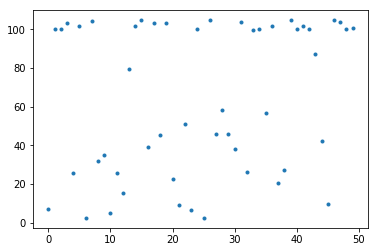

In [101]:
plt.plot(np.array(res_dict["Full"])[:,0], '.')

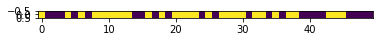

In [106]:
plt.imshow(np.array(res_dict["Full"])[:,-1:].astype(np.uint8).transpose())

In [92]:
for k, v in res_dict.items():
    print("{}:\n {}".format(k, np.array(v)[:,-1]))

Tool:
 [False False True False False True True False False False False True False
 True True False False True True False False False True True False True
 False False False True False False False False False False False True
 False False False False False False True True False True True False]
Full:
 [True False False False True False True False True True True True True
 True False False True False True False True True True True False True
 False True True True True False True True False True False True True
 False False False False True True True False False False False]
ToolReach:
 [False True True True False True True True True True True True False False
 True True False True True False True True True True False True True True
 True False False False True False False True True False True False True
 True True True False True True False False False]


In [93]:
idc_succ_all

array([ 6,  8,  9, 10, 11, 18, 20, 21, 22, 23, 25, 27, 28, 32, 35, 38, 43,
       45])